# PiB-PET Processing for Preclinical Alzheimer's Disease Consortium

The processing steps can be summarized as follows:
1. Time frame alignment
2. MRI-PET coregistration (MRIs have already been processed and anatomical regions have been defined)
3. Extraction of early amyloid (EA), SUVR, DVR, R<sub>1</sub> images
4. ROI summary calculation
5. Spatial normalization of all output images to MNI space

Steps 3-5 will be performed with and without partial volume correction.

In [368]:
# Import packages
import os, sys, logging
import pandas as pd
import numpy as np
import scipy as sp
import math
from glob import glob

# for plotting
import nibabel as nib
from nilearn.plotting import show, plot_stat_map, plot_anat, plot_img, plot_glass_brain, cm
from nilearn.image import iter_img
from nilearn.masking import apply_mask
from dipy.viz import regtools
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.pylabtools import figsize
%matplotlib inline

# nipype
import nipype.interfaces.io as nio
from nipype.interfaces import spm, fsl, petpvc
from nipype.pipeline.engine import Workflow, Node, JoinNode
from nipype.interfaces.utility import Function, IdentityInterface, Merge
from nipype.pipeline.plugins.callback_log import log_nodes_cb
from nipype_funcs import * # nipype_funcs.py must be in current working directory (or otherwise discoverable by python)
from nipype import config, logging
config.enable_debug_mode()
logging.update_logging(config)

In [369]:
# number of parallel processes
n_procs = 2

# Prototype script for QC reports
prototypescript = os.path.join(os.getcwd(), 'pib_qc.py')

# Use standalone SPM rather than through MATLAB
standalone_spm_dir = os.path.join(os.environ['SOFTWARE'], 'standalone_spm')

# directory to store the workflow results
output_dir = os.path.join(os.getcwd(), os.pardir, 'results', 'pib_processing_example')

# prefix for the data collection site
sitePrefix = 'BLSA'

# spreadsheet with the following columns: blsaid, blsavi, PIBpath, PIBtimingpath, musemripath, muselabelpath
organization_spreadsheet = os.path.join(os.getcwd(), os.pardir, 'inputs', 'PETstatus_08Feb2017.xlsx')

# columns required in the spreadsheet
required_cols = ['blsaid','blsavi','PIBpath','PIBtimingpath','musemripath','muselabelpath']

# values to be treated as missing in the spreadsheet - do not include NA as a null value as it is a valid EMSID
NAN_VALUES = ['-1.#IND', '1.#QNAN', '1.#IND', '-1.#QNAN', '#N/A','N/A', '#NA', 'NULL', 'NaN', '-NaN', 'nan', '-nan','']

In [370]:
# PiB processing parameters
# 2-min mean, used for time frame realignment
startTime_2min = 0.75
endTime_2min = 2

# 20-min mean, used for MRI coregistration
startTime_20min = 0.75
endTime_20min = 20

# 5-min mean, used for early amyloid image computation
startTime_EA = 0.75
endTime_EA = 5

# 50 to 70-min mean, used for SUVR computation
startTime_50to70min = 50
endTime_50to70min = 70

# 40 to 60-min mean, used for SUVR computation
startTime_40to60min = 40
endTime_40to60min = 60

# Used for DVR computation
endTime_DVR = 60

# PVC smoothing parameters: PET scanner PSF FWHM (in mm)
pvc_fwhm_x = 6.7
pvc_fwhm_y = 6.7
pvc_fwhm_z = 6.7

# Smoothing parameter (in mm) used for SUVR and SRTM
smooth_fwhm = 4.25

# For trimmed mean of ROI signal, proportion to cut (exclude) from each tail of the distribution
proportiontocut = 0.05

In [371]:
# Set up standalone SPM
matlab_cmd = os.path.join(standalone_spm_dir,'spm12','run_spm12.sh') + ' ' + \
             os.path.join(standalone_spm_dir,'MCR','v713' + ' script')

spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)
spm.SPMCommand().version # testing

'12.6914'

In [372]:
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

In [373]:
# LOGGING


In [374]:
# Read in the organization spreadsheet and extract information
data_table = pd.read_excel(organization_spreadsheet, keep_default_na=False, na_values=NAN_VALUES)

for col in required_cols:
    if not col in data_table.columns:
        sys.exit('Required column ' + col + ' is not present in the data organization spreadsheet ' + \
                 organization_spreadsheet + '!')

# Find all visits with PiB-PET (excluding incomplete/interrupted PiB scans) and MUSE labels
data_table = data_table[required_cols].dropna(axis=0, how='any')

#mri_list = pib_data['mripath'].values.tolist()
musemri_list = data_table['musemripath'].values.tolist()
muselabel_list = data_table['muselabelpath'].values.tolist()
pib_list = data_table['PIBpath'].values.tolist()
pibtiming_list = data_table['PIBtimingpath'].values.tolist()

subjID = data_table['blsaid'].values.tolist()
visNo = data_table['blsavi'].values.tolist()
blsavi_integer = [ math.floor(x) for x in visNo ]
blsavi_decimal = [ str(x).split('.')[1] for x in visNo ]

idvi_list = ["%04d_%02d-%s" % idvi for idvi in zip(subjID,blsavi_integer,blsavi_decimal)]

# Form dictionaries, with IDs as keys and paths to images as values
pib_dict = dict(zip(idvi_list, pib_list))
pibtiming_dict = dict(zip(idvi_list, pibtiming_list))
musemri_dict = dict(zip(idvi_list, musemri_list))
muselabel_dict = dict(zip(idvi_list, muselabel_list))

## 1. INPUTS

We set up the nipype Nodes that will act as the inputs to our Workflows. The `infosource` Node allows for iterating over scan IDs. The remaining input Nodes allow for the retrieval of the PiB, processed MRI, and label images given the scan IDs (`getpib`, `getmusemri`, `getmuselabel`, respectively), as well as the retrieval of the text files detailing the frame timing information (`getpibtiming`).

In [375]:
# placeholder Node to enable iteration over scans
infosource = Node(interface=IdentityInterface(fields=['idvi']),
                  name="infosource")
infosource.iterables = ('idvi', idvi_list)

# get full path to PiB scan corresponding to idvi from spreadsheet
getpib = Node(Function(input_names=['key','dict'],
                       output_names=['pib'],
                       function=get_value),
              name='getpib')
getpib.inputs.dict = pib_dict

# get full path to the txt file listing the duration of each PiB time frame
#  number of rows must be the same as the number of PiB time frames, with each row listing the time in minutes
getpibtiming = Node(Function(input_names=['key','dict'],
                             output_names=['pibtiming'],
                             function=get_value),
                    name='getpibtiming')
getpibtiming.inputs.dict = pibtiming_dict

# get full path to MRI corresponding to idvi from spreadsheet, in same space as MUSE labels
getmusemri = Node(Function(input_names=['key','dict'],
                           output_names=['musemri'],
                           function=get_value),
                  name='getmusemri')
getmusemri.inputs.dict = musemri_dict

# get full path to MUSE label image corresponding to idvi from spreadsheet, in same space as MRI
getmuselabel = Node(Function(input_names=['key','dict'],
                             output_names=['muselabel'],
                             function=get_value),
                    name='getmuselabel')
getmuselabel.inputs.dict = muselabel_dict

Normally, we wouldn't run the following line, but for demonstration purposes here, we are going to run the Workflows on a single scan. Thus, we include only the first scan ID in our iterable list.

In [376]:
infosource = Node(interface=IdentityInterface(fields=['idvi']),
                  name="infosource")
infosource.iterables = ('idvi', idvi_list[:1])

idvi_example = idvi_list[0]

## 2. REALIGN

The goal of the realign workflow is to compute a spatially-aligned dynamic PiB-PET image by removing subject motion.

* `reorient`: We start by reorienting the PET image to match the orientation of MNI152 templates. This is not spatial normalization - no registration is performed. We simply apply 90, 180, or 270 degree rotations as needed about the $x,y,z$ axes to match the MNI152 orientation.

We will align each time frame to the average of the first 2 minutes of acquisition. We use the first 2 minutes because they do not reflect amyloid binding but instead reflect blood flow, which has better anatomical definition that aids in the registration. We assume that the time frames in the first 2 minutes are in alignment, so we will not apply any spatial transformations to these frames.

* `split_time_2mins`: Split the dynamic scan into $< 2$ min and $\geq 2$ min.
* `dynamic_mean_2min`: Compute the average of the time frames in the $< 2$ mins.

We are going to use SPM's Realign function to perform time frame alignment, using the "align to first time frame" option. Thus, we create an artificial image where the first frame is the 2-min average, and the following frames are the dynamic scan frames $\geq 2$ min.

* `merge_lists`: Concatenates the full paths to the 2-min average image and time frames $\geq 2$ min, separated by a space.
* `merge_time`: Takes the concatenated string and performs the image concatenation.
* `pad`: In order to minimize interpolation artifacts at image edges, we pad each time frame on each of the 6 sides with the nearest slice prior to time frame alignment.
* `realign`: This is the SPM function to do the actual work.
* `unpad`: We reverse the padding to return to original image dimensions.
* `drop_first_timeframe`: We had artifically put this first time frame (which is the 2-min average) to get SPM's realign function to work. We remove it after realignment.
* `nan_to_0`: In case SPM transformations introduced any nan's (due to voxels coming into view from outside of the original image), we set these to 0 to avoid problems down the line.
* `merge_lists2` and `merge_time2`: We need to add back the first 2-minutes of time frames to the beginning of the realigned image.

_Note:_ For acquisitions that do not include time frames $< 2$ minutes post-injection, we align to the mean of the entire acquisition. This is achieved directly by setting the proper SPM Realign options. SPM uses a two-pass procedure when aligning to the mean image.

In [405]:
# Reorient
reorient = Node(interface=fsl.Reorient2Std(output_type='NIFTI'), name="reorient")

# Split the dynamic scan at the 2 min mark
split_time_2mins = Node(interface=SplitTimeSeries(splitTime=endTime_2min), name="split_time_2mins")

# Compute 0.75-2 min average that will be used for time frame alignment
dynamic_mean_2min = Node(interface=DynamicMean(startTime=startTime_2min, endTime=endTime_2min), name="dynamic_mean_2min")

merge_lists = Node(interface=Merge(2), name="merge_lists")
merge_time = Node(interface=fsl.Merge(dimension='t', output_type='NIFTI_PAIR'), name="merge_time")
# output type is NIFTI_PAIR because that is what SPM (used for realign) likes

pad = Node(interface=Pad4DImage(padsize=1),name="pad")
unpad = Node(interface=Unpad4DImage(padsize=1),name="unpad")

# Realign time frames
realign = Node(interface=spm.Realign(), name="realign")
# === Estimate options ===
realign.inputs.quality = 1
realign.inputs.separation = 4 # Separation in mm b/w points sampled in reference
                              # image. Smaller more accurate but slower
realign.inputs.fwhm = 7 # FWHM in mm of the Gaussian smoothing kernel applied
                        # to the images before estimating realignment parameters
realign.inputs.register_to_mean = False # align to the first time frame,
                                        # which we've hacked to be the 2 min avg
realign.inputs.interp = 2 # degree of interpolation. Higher is better but slower
realign.inputs.wrap = [0, 0, 0] # no wrap around in PET
# === Reslice options ===
realign.inputs.write_which = [1, 0] # do not to reslice the first timeframe
realign.inputs.write_interp = 4
realign.inputs.write_mask = True
realign.inputs.write_wrap = [0, 0, 0]
realign.inputs.out_prefix = 'r'
realign.inputs.jobtype = 'estwrite'
realign.use_mcr = True # run using standalone SPM (without MATLAB)

# After alignment, drop first time frame, which is the 2 min average
drop_first_timeframe = Node(interface=fsl.ExtractROI(t_min=1,t_size=-1), name="drop_first_timeframe")

# Replace nan values after realignment with 0
nan_to_0 = Node(interface=fsl.ImageMaths(op_string=' -nan', suffix='_nanto0'), name='nan_to_0')

merge_lists2 = Node(interface=Merge(2), name="merge_lists2")
merge_time2 = Node(interface=fsl.Merge(dimension='t'), name="merge_time2")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','realign_wf')
datasink.inputs.substitutions = [('_idvi_',sitePrefix+'_'),
                                 ('_roi',''),
                                 ('_merged',''),
                                 ('mean','avg2min'),
                                 ('_reoriented','')]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r'')]

realign_workflow = Workflow(name="realign_workflow")
realign_workflow.base_dir = os.path.join(output_dir,'realign_workingdir')
realign_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'realign_crashdumps')}}
realign_workflow.connect([(getpib, reorient, [('pib','in_file')]),
                          # get time frames beyond first two minutes (we assume first 2 mins are free of motion)
                          (reorient, split_time_2mins, [('out_file','timeSeriesImgFile')]),
                          (getpibtiming, split_time_2mins, [('pibtiming','frameTimingCsvFile')]),

                          # compute 0.75-2 min average (initial frames are excluded due to insufficient SNR)
                          (reorient, dynamic_mean_2min, [('out_file','timeSeriesImgFile')]),
                          (getpibtiming, dynamic_mean_2min, [('pibtiming','frameTimingCsvFile')]),

                          # perform time alignment to the average of first 2 mins
                          (dynamic_mean_2min, merge_lists, [('meanImgFile','in1')]),
                          (split_time_2mins, merge_lists, [('secondImgFile','in2')]),
                          (merge_lists, merge_time, [('out','in_files')]),

                          (merge_time, pad, [('merged_file','timeSeriesImgFile')]),
                          (pad, realign, [('paddedImgFile','in_files')]),
                          (realign, unpad, [('realigned_files','timeSeriesImgFile')]),
                          (unpad, drop_first_timeframe, [('unpaddedImgFile','in_file')]),

                          (drop_first_timeframe, nan_to_0, [('roi_file','in_file')]),

                          # put together the first 2 minutes with the rest of the time frames, which have been motion-corrected
                          (split_time_2mins, merge_lists2, [('firstImgFile','in1')]),
                          (nan_to_0, merge_lists2, [('out_file','in2')]),
                          (merge_lists2, merge_time2, [('out','in_files')]),

                          # save outputs
                          (dynamic_mean_2min, datasink, [('meanImgFile','avg2min')]), # 0.75-2min average (3D image) used in time frame alignment
                          (merge_time2, datasink, [('merged_file','realigned')]), # realigned time series (4D image)
                          (realign, datasink, [('realignment_parameters','realigned.@par')]), # realignment parameters
                         ])

We connect the inputs to the realignment workflow and run:

In [406]:
pib_workflow = Workflow(name="pib_workflow")
pib_workflow.base_dir = output_dir
pib_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'pib_crashdumps')}}
pib_workflow.connect([# PET time frame realignment
                      (infosource, realign_workflow, [('idvi','getpib.key'),
                                                      ('idvi','getpibtiming.key')])
                    ])
result = pib_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})

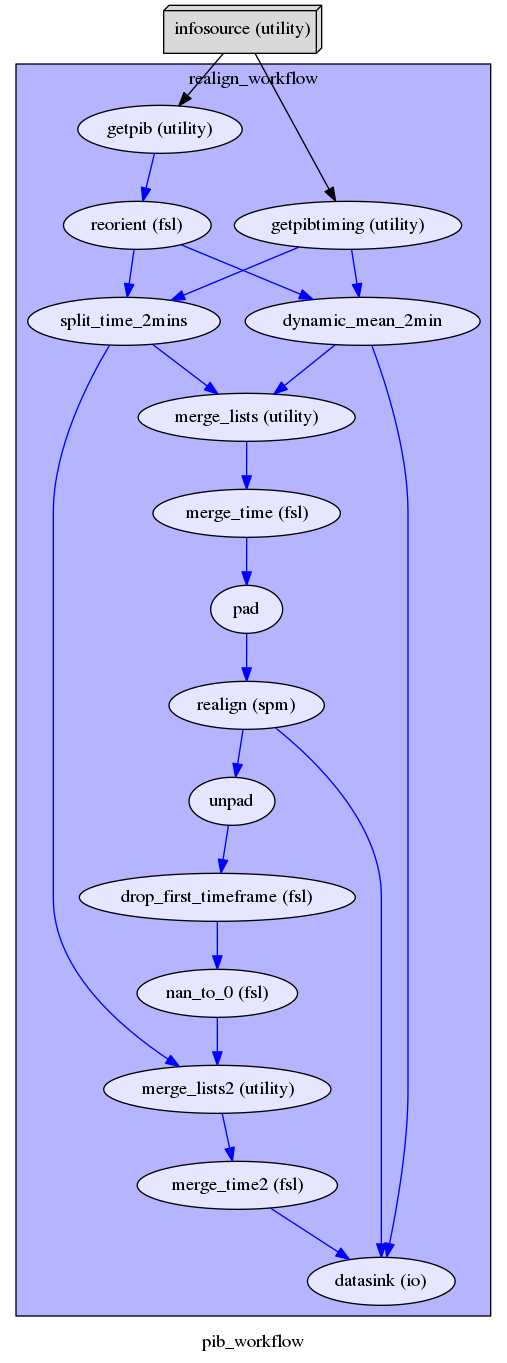

In [379]:
pib_workflow.write_graph('realign.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'pib_workflow','realign.dot.png'))

### 2.1 REALIGN QUALITY CONTROL

Using the `datasink` in the realignment workflow, we saved copies of the main outputs of interest into a subdirectory named `output/realign_wf`. Using this output, we perform some quality control and visual checks of the results. First, we read in the frame timing csv file for this scan and extract frame start and end times.

In [380]:
frameTimingCsvFile = pibtiming_dict[idvi_example]
splitTime = endTime_2min

frameTiming = pd.read_csv(frameTimingCsvFile)
# check that frameTiming has columns named frameStart and frameEnd
for col in ['frameStart','frameEnd']:
    if not col in frameTiming.columns:
        sys.exit('Required column '+col+' is not present in the frame timing spreadsheet '+frameTimingCsvFile+'!')
frameStart = frameTiming['frameStart']
frameEnd = frameTiming['frameEnd']
# sanity checks on frameTiming spreadsheet entries
assert(len(frameTiming)>1)
assert(all(frameStart<frameEnd))
assert(all(frameStart[1:]==frameEnd[:len(frameEnd)-1]))

frameStart = frameStart.as_matrix() #tolist()
frameEnd = frameEnd.as_matrix() #tolist()

splitIndex = next((i for i,t in enumerate(frameStart) if t>=splitTime), len(frameTiming))

# Compute the time mid-way for each time frame, to be used for plotting purposes
t = (frameStart + frameEnd)/2

Next, we extract the translation and rotation parameters from SPM realignment, and plot them over time to make sure that there is no wild subject motion.

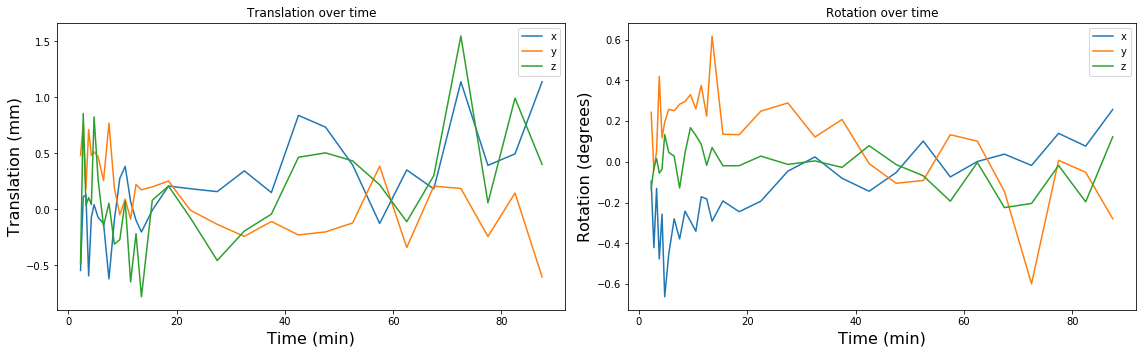

In [381]:
realignParamsFile = glob(os.path.join(output_dir,'output','realign_wf','realigned',sitePrefix+'_'+idvi_example,
                                     'rp_*.txt'))[0]

# Time realignment parameters
rp = pd.read_csv(realignParamsFile,delim_whitespace=True, header=None).as_matrix()
translation = rp[1:,:3]
rotation = rp[1:,3:] * 180 / math.pi

plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(t[splitIndex:],translation[:,0],label='x')
plt.plot(t[splitIndex:],translation[:,1],label='y')
plt.plot(t[splitIndex:],translation[:,2],label='z')
plt.legend(loc=0)
plt.title('Translation over time')
plt.xlabel('Time (min)', fontsize=16)
plt.ylabel('Translation (mm)', fontsize=16)

plt.subplot(122)
plt.plot(t[splitIndex:],rotation[:,0],label='x')
plt.plot(t[splitIndex:],rotation[:,1],label='y')
plt.plot(t[splitIndex:],rotation[:,2],label='z')
plt.legend(loc=0)
plt.title('Rotation over time')
plt.xlabel('Time (min)', fontsize=16)
plt.ylabel('Rotation (degrees)', fontsize=16)

plt.tight_layout()

Finally, we visualize time frames of the realigned scan.

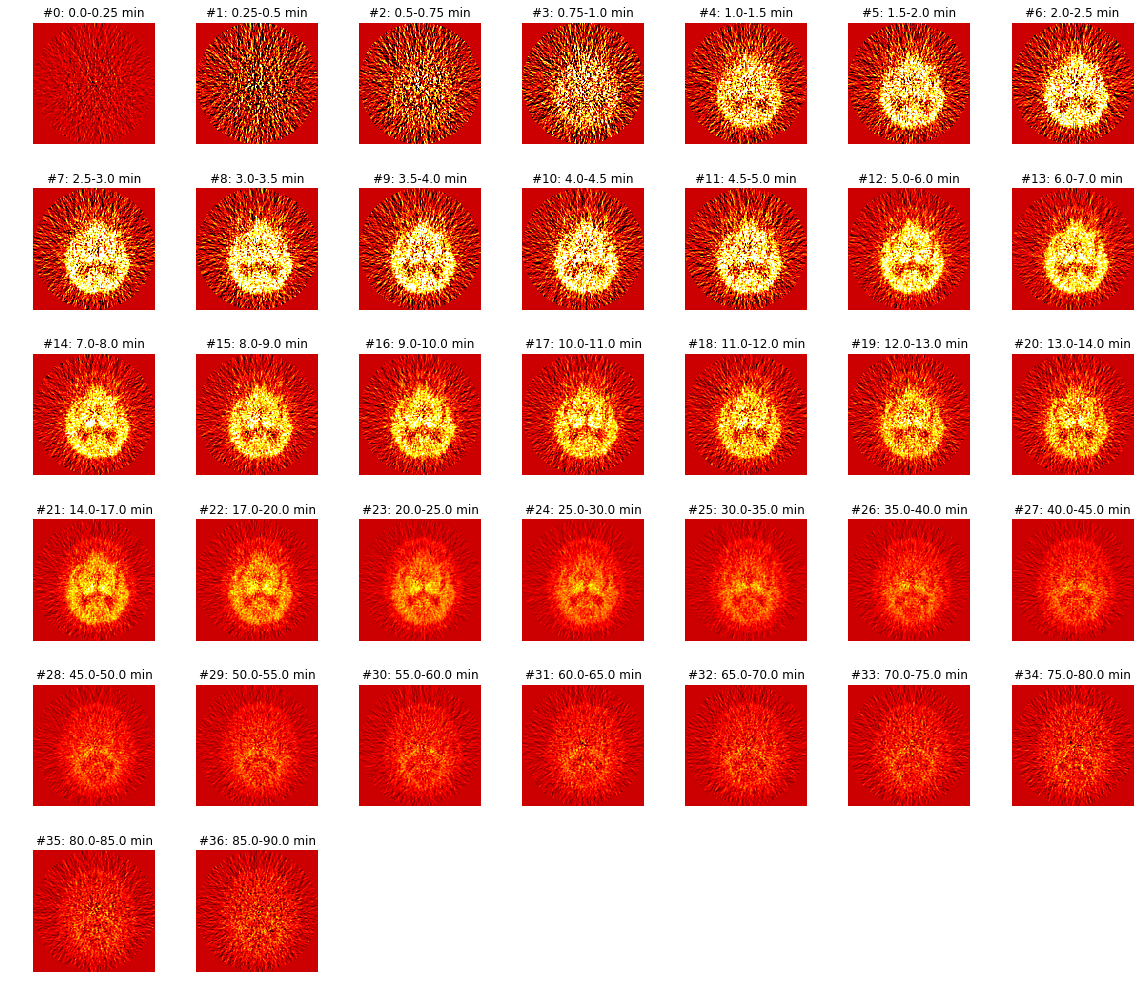

In [382]:
petrealignedfile = glob(os.path.join(output_dir,'output','realign_wf','realigned',sitePrefix+'_'+idvi_example,
                                     '*.nii*'))[0]

petrealigned = nib.load(petrealignedfile)
I = petrealigned.get_data()
imdim = I.shape
vmin, vmax = np.percentile(I,[1,99])
voxsize = petrealigned.header.get_zooms()

# Right hemisphere is on the right hand side
plt.figure(figsize=(16,16))
for tt in range(imdim[3]):
    plt.subplot(np.ceil(np.sqrt(imdim[3])),np.ceil(np.sqrt(imdim[3])),tt+1)
    plt.imshow(np.fliplr(I[:,:,imdim[2]//2,tt]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.title('#'+str(tt)+': '+str(frameStart[tt])+'-'+str(frameEnd[tt])+' min')
plt.tight_layout()

## 3. MRI-PET COREGISTRATION

Our goal is to perform image processing in native PET space to produce parametric images. We have chosen this approach (rather than processing in native MRI space) for two reasons:
1. This approach avoids the use of PET data interpolated to match the voxel size of the MRI scans for generating parametric images. Such an interpolation is undesirable because of the large difference between PET and MRI voxel sizes.
2. Fewer brain voxels in native PET space allows for faster computation of voxelwise kinetic parameters for the whole brain.

It should be noted that PET space processing is not without disadvantages. Anatomical labels have to be interpolated to match the PET voxel size, which yields inaccuracies. While these inaccuracies are not important for reference region or ROI definitions for computing averages, they are influential for partial volume correction.

We have structural MRIs that have already been preprocessed and anatomically labeled. To bring anatomical labels to PET space, we will perform coregistration of the PET and the MRI.

* `dynamic_mean_20min`: We compute the average of PiB time frames $<20$ mins, which will be used in the coregistration.
* `reorientmri` and `reorientlabel`:  Apply 90, 180, or 270 degree rotations as needed about the $x,y,z$ axes to match the MNI152 orientation.
* `pet_to_mri`: We use the image with finer spatial resolution (MRI) as the reference, and the PiB 20-min average as the moving image, to perform rigid alignment with normalized mutual information cost function, using FSL's FLIRT method.
* `invertTransform`: Since we want anatomical labels in PET space, we invert the rigid transformation.
* `mri_to_pet` and `labels_to_pet`: We apply the inverted transformation to the MRI and anatomical labels to bring them to PET space.

_Note:_ For acquisitions that do not allow for the computation of a 20-min average image, we use the mean of the entire acquisition to perform coregistration with the MRI.

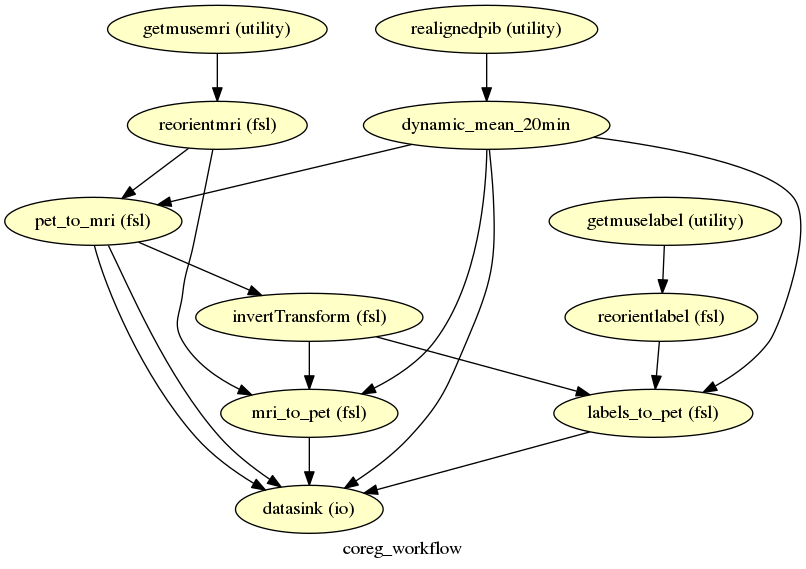

In [407]:
# a placeholder for the realigned 4D PiB
realignedpib = Node(interface=IdentityInterface(fields=['pib']), name="realignedpib")

# Compute 0.75-20 min average that will be used for MRI coregistration
dynamic_mean_20min = Node(interface=DynamicMean(startTime=startTime_20min, endTime=endTime_20min),
                          name="dynamic_mean_20min")

# Reorient MRI and label
reorientmri = Node(interface=fsl.Reorient2Std(output_type='NIFTI'), name="reorientmri")
reorientlabel = Node(interface=fsl.Reorient2Std(output_type='NIFTI'), name="reorientlabel")

# MRI coregistration, rigid, with normalized mutual information
pet_to_mri = Node(interface=fsl.FLIRT(cost='normmi', dof=6, 
                                      searchr_x=[-30,30], searchr_y=[-30,30], searchr_z=[-30,30],
                                      coarse_search=15, fine_search=6), 
                  name="pet_to_mri")

invertTransform = Node(interface=fsl.ConvertXFM(invert_xfm=True), name="invertTransform")
mri_to_pet = Node(interface=fsl.ApplyXfm(apply_xfm=True), name="mri_to_pet")
labels_to_pet = Node(interface=fsl.ApplyXfm(apply_xfm=True, interp='nearestneighbour'), name="labels_to_pet")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','coreg_wf')
datasink.inputs.substitutions = [('_idvi_',sitePrefix+'_'),
                                 ('_roi',''),
                                 ('_merged',''),
                                 ('mean','avg20min'),
                                 ('flirt','coreg'),
                                 ('_reoriented','')]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r'')]

coreg_workflow = Workflow(name="coreg_workflow")
coreg_workflow.base_dir = os.path.join(output_dir,'coreg_workingdir')
coreg_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'coreg_crashdumps')}}
coreg_workflow.connect([(getmusemri, reorientmri, [('musemri','in_file')]),
                        (getmuselabel, reorientlabel, [('muselabel','in_file')]),

                        (realignedpib, dynamic_mean_20min, [('pib','timeSeriesImgFile')]),

                        (dynamic_mean_20min, pet_to_mri, [('meanImgFile','in_file')]),
                        (reorientmri, pet_to_mri, [('out_file','reference')]),

                        (pet_to_mri, invertTransform, [('out_matrix_file','in_file')]),

                        (reorientmri, mri_to_pet, [('out_file','in_file')]),
                        (dynamic_mean_20min, mri_to_pet, [('meanImgFile','reference')]),
                        (invertTransform, mri_to_pet, [('out_file','in_matrix_file')]),

                        (reorientlabel, labels_to_pet, [('out_file','in_file')]),
                        (dynamic_mean_20min, labels_to_pet, [('meanImgFile','reference')]),
                        (invertTransform, labels_to_pet, [('out_file','in_matrix_file')]),

                        # save outputs
                        (dynamic_mean_20min, datasink, [('meanImgFile','avg20min')]), # 0.75-20min average (3D image) used for MRI coregistration
                        (pet_to_mri, datasink, [('out_file','coreg_avg20min'),
                                                ('out_matrix_file','coreg_avg20min.@param')]),
                        (mri_to_pet, datasink, [('out_file','coreg_mri')]), # MRI registered onto PET
                        (labels_to_pet, datasink, [('out_file','coreg_labels')]) # anatomical labels on PET
                       ])
coreg_workflow.write_graph('coreg.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'coreg_workingdir','coreg_workflow','coreg.dot.png'))

In [408]:
pib_workflow.connect([# PET-to-MRI registration
                      (infosource, coreg_workflow, [('idvi','getmusemri.key'),
                                                    ('idvi','getmuselabel.key')]),
                      (realign_workflow, coreg_workflow, [('merge_time2.merged_file','realignedpib.pib'),
                                                          ('getpibtiming.pibtiming','dynamic_mean_20min.frameTimingCsvFile')])
                     ])
result = pib_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})

### 3.1 MRI-PET COREGISTRATION QUALITY CONTROL

/usr/local/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


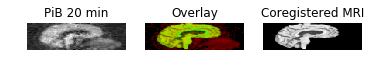

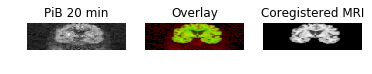

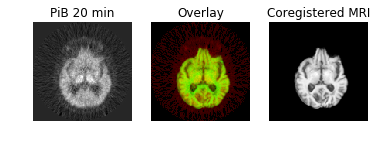

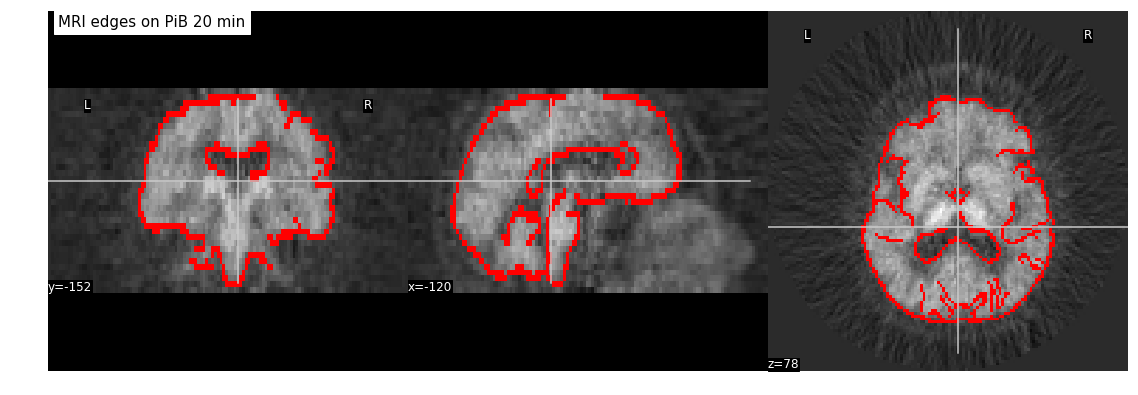

In [385]:
pib20minfile = glob(os.path.join(output_dir,'output','coreg_wf','avg20min',sitePrefix+'_'+idvi_example,
                                     '*.nii*'))[0]
mriregfile = glob(os.path.join(output_dir,'output','coreg_wf','coreg_mri',sitePrefix+'_'+idvi_example,
                                     '*.nii*'))[0]
mrireg = nib.load(mriregfile)
pib20min = nib.load(pib20minfile)

# Visualize the overlaid PiB 20-min average and the coregistered MRI
p = regtools.overlay_slices(pib20min.get_data(), mrireg.get_data(), None, 0, "PiB 20 min", "Coregistered MRI")
p = regtools.overlay_slices(pib20min.get_data(), mrireg.get_data(), None, 1, "PiB 20 min", "Coregistered MRI")
p = regtools.overlay_slices(pib20min.get_data(), mrireg.get_data(), None, 2, "PiB 20 min", "Coregistered MRI")

# Visualize edges detected using coregistered MRI on the PiB 20-min average
fig = plt.figure(figsize=(15,5))
display = plot_anat(pib20minfile,figure=fig)
display.add_edges(mriregfile)
display.title('MRI edges on PiB 20 min')

## 4. LABELS

We manipulate the anatomical label image to define the reference region for kinetic parameter computation, designate ROIs for partial volume correction, and determine composite ROIs for regional average reporting. Below, we define which MUSE label indices and their combinations form these three categories.

In [386]:
# ROI groupings for reference region
reference_ROI_grouping = {'cerebellar GM':[38,39,71,72,73]}

# ROI groupings for PVC based on MUSE labels
pvc_ROI_groupings = \
{
    'background':[0],          
    'ventricles and CSF':[-1,4,11,46,49,50,51,52], # includes non-WM-hypointensities. -1 is a label we will generate to approximate sulcal CSF
    'basal ganglia':[23,30,36,37,55,56,57,58,75,76], # striatum (caudate, putamen), pallidum, nucleus accumbens, substantia nigra, basal forebrain
    'thalamus':[59,60],
    'brainstem':[35], # combine with thalamus?
    'hippocampus':[47,48],
    'amygdala':[31,32],
    'cerebral WM':[61,62,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], # includes fornix, internal capsule, corpus callosum, ventral DC
    'inferior frontal GM':[104,105,136,137,146,147,178,179],
    'lateral frontal GM':[120,121,142,143,162,163,164,165,182,183,190,191,204,205],
    'medial frontal GM':[124,125,140,141,150,151,152,153,186,187,192,193],
    'opercular frontal GM':[112,113,118,119,174,175],
    'lateral parietal GM':[106,107,176,177,194,195,198,199],
    'medial parietal GM':[148,149,168,169],
    'inferior temporal GM':[122,123],
    'lateral temporal GM':[132,133,154,155,200,201,202,203],
    'supratemporal GM':[180,181,184,185,206,207],
    'inferior occipital GM':[160,161],
    'lateral occipital GM':[128,129,144,145,156,157,196,197],
    'medial occipital GM':[108,109,114,115,134,135],
    'limbic medial temporal GM':[116,117,170,171],
    'cingulate GM':[100,101,138,139,166,167],
    'insula GM':[102,103,172,173],
    'cerebellar WM':[40,41],
    'cerebellar GM':[38,39,71,72,73]
}

# ROIs for report spreadsheet
ROIs = \
{
    '3rd Ventricle':4,'4th Ventricle':11,'Right Accumbens Area':23,'Left Accumbens Area':30,
    'Right Amygdala':31,'Left Amygdala':32,'Brain Stem':35,'Right Caudate':36,'Left Caudate':37,
    'Right Cerebellum Exterior':38,'Left Cerebellum Exterior':39,
    'Right Cerebellum White Matter':40,'Left Cerebellum White Matter':41,
    'Right Hippocampus':47,'Left Hippocampus':48,'Right Inf Lat Vent':49,'Left Inf Lat Vent':50,
    'Right Lateral Ventricle':51,'Left Lateral Ventricle':52,'Right Pallidum':55,'Left Pallidum':56,
    'Right Putamen':57,'Left Putamen':58,'Right Thalamus Proper':59,'Left Thalamus Proper':60,
    'Right Ventral DC':61,'Left Ventral DC':62,
    'Cerebellar Vermal Lobules I-V':71,'Cerebellar Vermal Lobules VI-VII':72,'Cerebellar Vermal Lobules VIII-X':73,
    'Left Basal Forebrain':75,'Right Basal Forebrain':76,'frontal lobe WM right':81,'frontal lobe WM left':82,
    'occipital lobe WM right':83,'occipital lobe WM left':84,'parietal lobe WM right':85,'parietal lobe WM left':86,
    'temporal lobe WM right':87,'temporal lobe WM left':88,'fornix right':89,'fornix left':90,
    'anterior limb of internal capsule right':91,'anterior limb of internal capsule left':92,
    'posterior limb of internal capsule inc. cerebral peduncle right':93,
    'posterior limb of internal capsule inc. cerebral peduncle left':94,
    'corpus callosum':95,'Right ACgG  anterior cingulate gyrus':100,'Left ACgG  anterior cingulate gyrus':101,
    'Right AIns  anterior insula':102,'Left AIns  anterior insula':103,
    'Right AOrG  anterior orbital gyrus':104,'Left AOrG  anterior orbital gyrus':105,
    'Right AnG   angular gyrus':106,'Left AnG   angular gyrus':107,
    'Right Calc  calcarine cortex':108,'Left Calc  calcarine cortex':109,
    'Right CO    central operculum':112,'Left CO    central operculum':113,
    'Right Cun   cuneus':114,'Left Cun   cuneus':115,
    'Right Ent   entorhinal area':116,'Left Ent   entorhinal area':117,
    'Right FO    frontal operculum':118,'Left FO    frontal operculum':119,
    'Right FRP   frontal pole':120,'Left FRP   frontal pole':121,
    'Right FuG   fusiform gyrus':122,'Left FuG   fusiform gyrus':123,
    'Right GRe   gyrus rectus':124,'Left GRe   gyrus rectus':125,
    'Right IOG   inferior occipital gyrus':128,'Left IOG   inferior occipital gyrus':129,
    'Right ITG   inferior temporal gyrus':132,'Left ITG   inferior temporal gyrus':133,
    'Right LiG   lingual gyrus':134,'Left LiG   lingual gyrus':135,
    'Right LOrG  lateral orbital gyrus':136,'Left LOrG  lateral orbital gyrus':137,
    'Right MCgG  middle cingulate gyrus':138,'Left MCgG  middle cingulate gyrus':139,
    'Right MFC   medial frontal cortex':140,'Left MFC   medial frontal cortex':141,
    'Right MFG   middle frontal gyrus':142,'Left MFG   middle frontal gyrus':143,
    'Right MOG   middle occipital gyrus':144,'Left MOG   middle occipital gyrus':145,
    'Right MOrG  medial orbital gyrus':146,'Left MOrG  medial orbital gyrus':147,
    'Right MPoG  postcentral gyrus medial segment':148,'Left MPoG  postcentral gyrus medial segment':149,
    'Right MPrG  precentral gyrus medial segment':150,'Left MPrG  precentral gyrus medial segment':151,
    'Right MSFG  superior frontal gyrus medial segment':152,'Left MSFG  superior frontal gyrus medial segment':153,
    'Right MTG   middle temporal gyrus':154,'Left MTG   middle temporal gyrus':155,
    'Right OCP   occipital pole':156,'Left OCP   occipital pole':157,
    'Right OFuG  occipital fusiform gyrus':160,'Left OFuG  occipital fusiform gyrus':161,
    'Right OpIFG opercular part of the inferior frontal gyrus':162,
    'Left OpIFG opercular part of the inferior frontal gyrus':163,
    'Right OrIFG orbital part of the inferior frontal gyrus':164,
    'Left OrIFG orbital part of the inferior frontal gyrus':165,
    'Right PCgG  posterior cingulate gyrus':166,'Left PCgG  posterior cingulate gyrus':167,
    'Right PCu   precuneus':168,'Left PCu   precuneus':169,
    'Right PHG   parahippocampal gyrus':170,'Left PHG   parahippocampal gyrus':171,
    'Right PIns  posterior insula':172,'Left PIns  posterior insula':173,
    'Right PO    parietal operculum':174,'Left PO    parietal operculum':175,
    'Right PoG   postcentral gyrus':176,'Left PoG   postcentral gyrus':177,
    'Right POrG  posterior orbital gyrus':178,'Left POrG  posterior orbital gyrus':179,
    'Right PP    planum polare':180,'Left PP    planum polare':181,
    'Right PrG   precentral gyrus':182,'Left PrG   precentral gyrus':183,
    'Right PT    planum temporale':184,'Left PT    planum temporale':185,
    'Right SCA   subcallosal area':186,'Left SCA   subcallosal area':187,
    'Right SFG   superior frontal gyrus':190,'Left SFG   superior frontal gyrus':191,
    'Right SMC   supplementary motor cortex':192,'Left SMC   supplementary motor cortex':193,
    'Right SMG   supramarginal gyrus':194,'Left SMG   supramarginal gyrus':195,
    'Right SOG   superior occipital gyrus':196,'Left SOG   superior occipital gyrus':197,
    'Right SPL   superior parietal lobule':198,'Left SPL   superior parietal lobule':199,
    'Right STG   superior temporal gyrus':200,'Left STG   superior temporal gyrus':201,
    'Right TMP   temporal pole':202,'Left TMP   temporal pole':203,
    'Right TrIFG triangular part of the inferior frontal gyrus':204,
    'Left TrIFG triangular part of the inferior frontal gyrus':205,
    'Right TTG   transverse temporal gyrus':206,'Left TTG   transverse temporal gyrus':207
}

# Composite ROIs for report spreadsheet
compositeROIs = dict(pvc_ROI_groupings,
                     **{'precuneus':[168,169],
                        'mean cortical':[100,101,104,105,106,107,112,113,118,119,120,121,124,125,
                                         128,129,132,136,137,138,139,140,141,142,143,144,145,146,147,
                                         152,153,154,155,156,157,162,163,164,165,166,167,168,169,
                                         174,175,178,179,180,181,184,185,186,187,190,191,192,193,
                                         194,195,196,197,198,199,200,201,202,203,204,205,206,207]})

# sanity check -- make sure there's no overlap across groups of labels
pvc_all_labels = [label for group in list(pvc_ROI_groupings.values()) for label in group]
assert(len(pvc_all_labels)==len(set(pvc_all_labels)))

There are two streams of processing we will pursue. First, we generate a conservative reference region definition:
* `reference_region`: Combines the selected MUSE labels to generate a binary mask.
* `erode`: To minimize partial voluming effects, we slightly erode the reference region mask using a $5\times5\times5$ mm box kernel.

Second, we generate the set of labels that will be used in partial volume correction. MUSE labels do not include a sulcal CSF label, but this is an important label for PVC. We approximate the sulcal CSF label as the rim around the brain. To this end, we dilate the brain mask, and subtract from it the original brain mask. We designate a label value of $-1$ to this rim, and include it with the ventricle and CSF ROI for PVC.
* `brainmask`: Threshold the MUSE label image to get a binary brain mask.
* `dilate`: Dilate the brain mask using a $5\times5\times5$ mm box kernel.
* `difference`: Subtract dilated brain mask from the orginal mask to get the rim around the brain. This subtraction assigns a value of $-1$ to the rim.
* `add`: We add the rim image to the MUSE label image. Since the MUSE label image has value $0$ where the rim image has non-zero values, the result is a label image that preserves all the MUSE labels and additionally has a "sulcal CSF" label with value $-1$.
* `pvc_labels`: We combine the ROIs to generate a collection of binary masks. The result is a 4D volume (with all the binary 3D masks concatenated along 4th dimension). This 4D volume will be an input to the PVC methods.

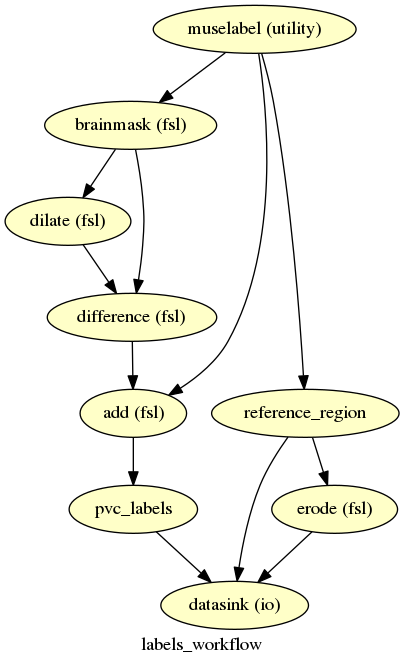

In [409]:
# placeholder
muselabel = Node(interface=IdentityInterface(fields=['muselabel']), name="muselabel")

reference_region = Node(interface=CombineROIs(ROI_groupings=list(reference_ROI_grouping.values())), 
                        name="reference_region")
erode = Node(interface=fsl.ErodeImage(kernel_shape='box',kernel_size=5), name="erode")

brainmask = Node(interface=fsl.ImageMaths(op_string=' -bin', suffix='_brainmask'), name='brainmask')
dilate = Node(interface=fsl.DilateImage(operation='max', kernel_shape='box', kernel_size=5), name='dilate')
difference = Node(interface=fsl.ImageMaths(op_string=' -sub ', suffix='_diff'), name='difference')
add = Node(interface=fsl.ImageMaths(op_string=' -add ', suffix='_add'), name='add')
pvc_labels = Node(interface=CombineROIs(ROI_groupings=list(pvc_ROI_groupings.values())), name="pvc_labels")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','labels_wf')
datasink.inputs.substitutions = [('_idvi_',sitePrefix+'_'),
                                 ('flirt','coreg'),
                                 ('_'+'{:d}'.format(len(reference_ROI_grouping))+'combinedROIs','_refRegion'),
                                 ('_'+'{:d}'.format(len(pvc_ROI_groupings))+'combinedROIs','_pvcLabels')
                                ]

labels_workflow = Workflow(name="labels_workflow")
labels_workflow.base_dir = os.path.join(output_dir,'labels_workingdir')
labels_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'labels_crashdumps')}}
labels_workflow.connect([(muselabel, reference_region, [('muselabel', 'labelImgFile')]),
                         (reference_region, erode, [('roi4DMaskFile','in_file')]),

                         # Assign a value of -1 to voxels surrounding the brain
                         # this is an approximation for sulcal CSF label
                         (muselabel, brainmask, [('muselabel','in_file')]),
                         (brainmask, dilate, [('out_file','in_file')]),
                         (brainmask, difference, [('out_file','in_file')]),
                         (dilate, difference, [('out_file','in_file2')]),
                         (muselabel, add, [('muselabel','in_file')]),
                         (difference, add,[('out_file','in_file2')]),
                         (add, pvc_labels, [('out_file','labelImgFile')]),

                         #(muselabel, pvc_labels, [('muselabel', 'labelImgFile')]),

                         (reference_region, datasink, [('roi4DMaskFile','reference_region')]),
                         (erode, datasink, [('out_file','reference_region.eroded')]),
                         (pvc_labels, datasink, [('roi4DMaskFile','pvc_labels')])
                        ])

labels_workflow.write_graph('labels.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'labels_workingdir','labels_workflow','labels.dot.png'))

In [410]:
pib_workflow.connect([# Anatomical label manipulation
                      (coreg_workflow, labels_workflow, [('labels_to_pet.out_file','muselabel.muselabel')])
                     ])
result = pib_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})

### 4.1 LABELS QUALITY CONTROL

/usr/local/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


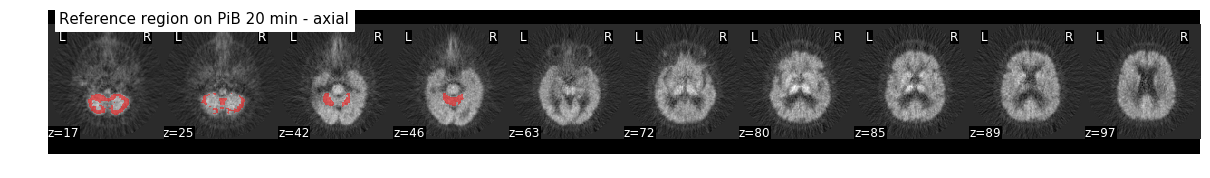

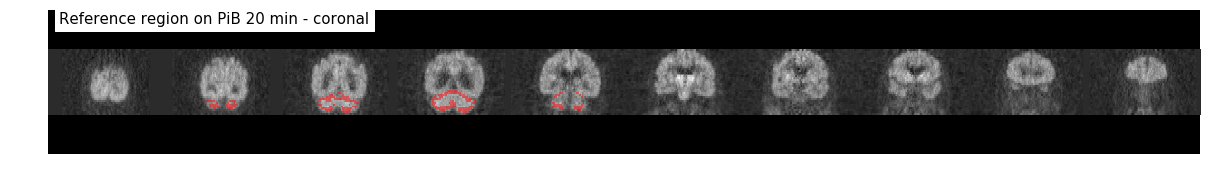

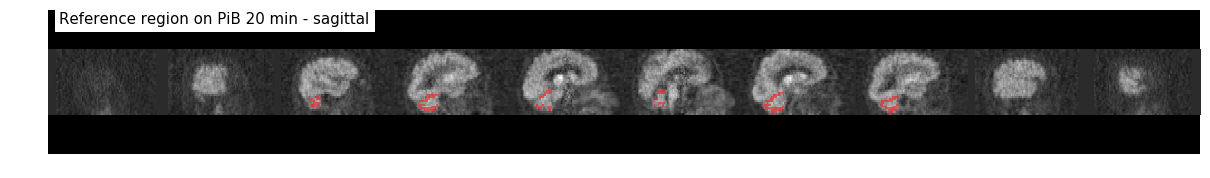

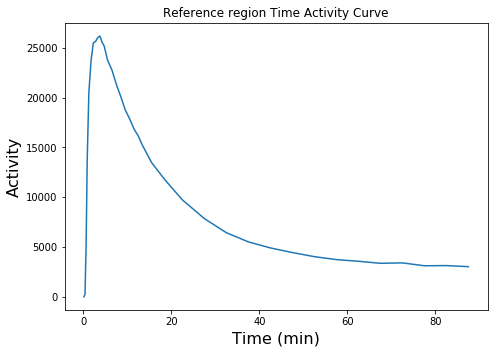

In [389]:
maskfile = glob(os.path.join(output_dir,'output','labels_wf','reference_region','eroded',sitePrefix+'_'+idvi_example,
                                     '*.nii*'))[0]

# Reference region superimposed on PiB 20 min mean
#fig = plt.figure(figsize=(16,4))
#display = plot_anat(pib20minfile, display_mode="ortho", figure=fig)
#display.add_overlay(maskfile, cmap=cm.red_transparent)

fig = plt.figure(figsize=(16,2))
display = plot_anat(pib20minfile,figure=fig, display_mode="z", cut_coords=10)
#display.add_edges(maskfile)
display.add_overlay(maskfile, cmap=cm.red_transparent)
display.title('Reference region on PiB 20 min - axial')

fig = plt.figure(figsize=(16,2))
display = plot_anat(pib20minfile,figure=fig, display_mode="y", cut_coords=10, annotate=False)
#display.add_edges(maskfile)
display.add_overlay(maskfile, cmap=cm.red_transparent)
display.title('Reference region on PiB 20 min - coronal')

fig = plt.figure(figsize=(16,2))
display = plot_anat(pib20minfile,figure=fig, display_mode="x", cut_coords=10, annotate=False)
#display.add_edges(maskfile)
display.add_overlay(maskfile, cmap=cm.red_transparent)
display.title('Reference region on PiB 20 min - sagittal')

# Reference region Time Activity Curve (TAC)
masked_data = apply_mask(petrealignedfile, maskfile)
ref_TAC = np.mean(masked_data,axis=1)

plt.figure(figsize=(7,5))
plt.plot(t,ref_TAC)
plt.title('Reference region Time Activity Curve')
plt.xlabel('Time (min)', fontsize=16)
plt.ylabel('Activity', fontsize=16)
plt.tight_layout()

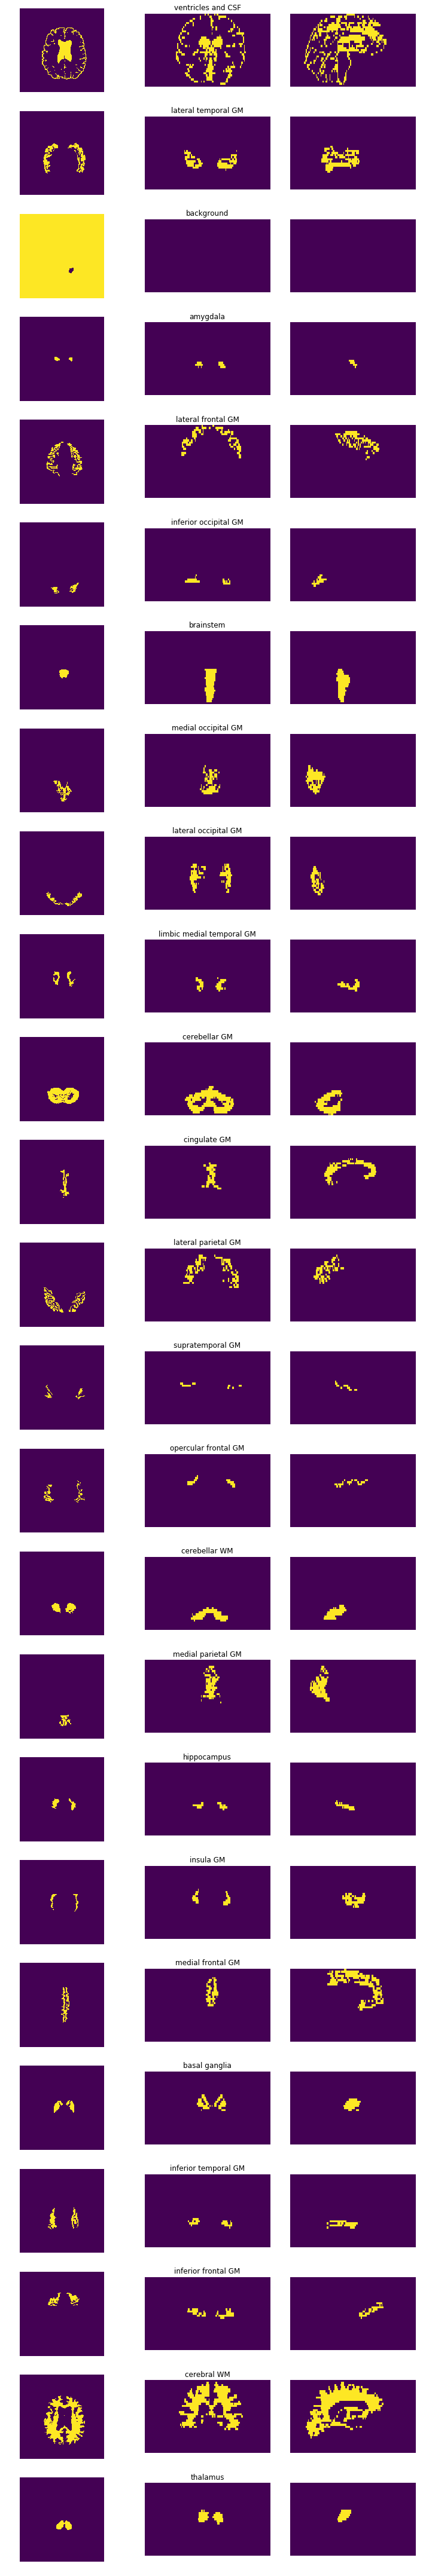

In [390]:
# PVC labels
pvclabelfile = glob(os.path.join(output_dir,'output','labels_wf','pvc_labels',sitePrefix+'_'+idvi_example,
                                     '*.nii*'))[0]
pvclabel = nib.load(pvclabelfile)
I = pvclabel.get_data()
imdim = I.shape
voxsize = pvclabel.header.get_zooms()

# Right hemisphere is on the right hand side
fig, axes = plt.subplots(imdim[3],3,figsize=(10,60))
for tt in range(imdim[3]):
    
    sli = np.argmax(np.sum(I[:,:,:,tt],axis=(0,1)))
    axes[tt,0].imshow(np.fliplr(I[:,:,sli,tt]).T, aspect=voxsize[1]/voxsize[0])
    axes[tt,0].set_axis_off()
    
    sli = np.argmax(np.sum(I[:,:,:,tt],axis=(0,2)))
    axes[tt,1].imshow(np.fliplr(I[:,sli,:,tt]).T, aspect=voxsize[2]/voxsize[0])
    axes[tt,1].set_axis_off()
    axes[tt,1].set_title(list(pvc_ROI_groupings.keys())[tt])
    
    sli = np.argmax(np.sum(I[:,:,:,tt],axis=(1,2)))
    axes[tt,2].imshow(np.fliplr(I[sli,:,:,tt]).T, aspect=voxsize[2]/voxsize[1])
    axes[tt,2].set_axis_off()
plt.tight_layout()

## 5. EARLY AMYLOID IMAGE

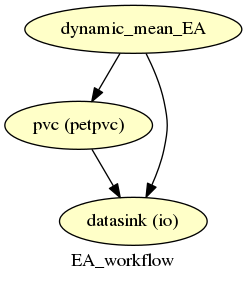

In [411]:
dynamic_mean_EA = Node(interface=DynamicMean(startTime=startTime_EA, endTime=endTime_EA), name="dynamic_mean_EA")

pvc = Node(interface=petpvc.PETPVC(pvc='RBV', fwhm_x=pvc_fwhm_x, fwhm_y=pvc_fwhm_y, fwhm_z=pvc_fwhm_z), name="pvc")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','EA_wf')
datasink.inputs.substitutions = [('_idvi_',sitePrefix+'_'),
                                 ('_merged',''),
                                 ('_flirt','_coreg'),
                                 ('_reoriented','')
                                ]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r'')]

EA_workflow = Workflow(name="EA_workflow")
EA_workflow.base_dir = os.path.join(output_dir,'EA_workingdir')
EA_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'EA_crashdumps')}}
EA_workflow.connect([(dynamic_mean_EA, pvc, [('meanImgFile','in_file')]),

                     (dynamic_mean_EA, datasink, [('meanImgFile','EA')]),
                     (pvc, datasink, [('out_file','EA_pvc')])
                    ])

EA_workflow.write_graph('EA.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'EA_workingdir','EA_workflow','EA.dot.png'))

In [412]:
pib_workflow.connect([# Early amyloid image
                      (coreg_workflow, EA_workflow, [('realignedpib.pib', 'dynamic_mean_EA.timeSeriesImgFile')]),
                      (realign_workflow, EA_workflow, [('getpibtiming.pibtiming','dynamic_mean_EA.frameTimingCsvFile')]),
                      (labels_workflow, EA_workflow, [('pvc_labels.roi4DMaskFile','pvc.mask_file')])
                     ])
result = pib_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})

(-0.5, 127.5, 34.5, -0.5)

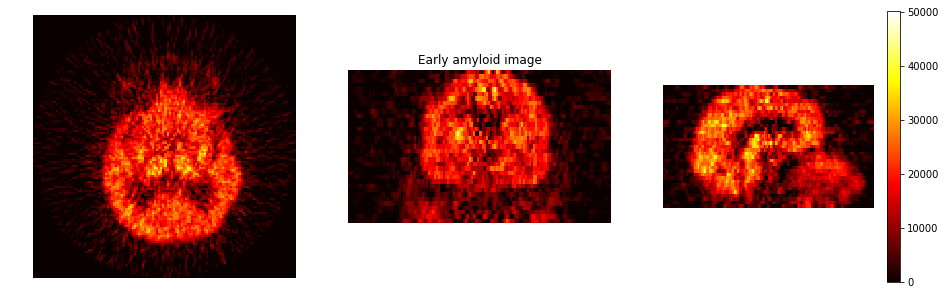

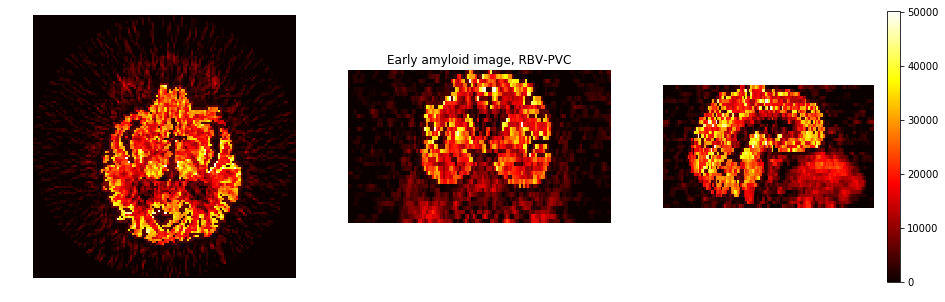

In [393]:
eafile = glob(os.path.join(output_dir,'output','EA_wf','EA',sitePrefix+'_'+idvi_example,
                                     '*.nii*'))[0]
eapvcfile = glob(os.path.join(output_dir,'output','EA_wf','EA_pvc',sitePrefix+'_'+idvi_example,
                                     '*.nii*'))[0]

ea = nib.load(eafile)
I = ea.get_data()
imdim = I.shape
voxsize = ea.header.get_zooms()
vmin, vmax = np.percentile(np.abs(I),[5,100])

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('Early amyloid image')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


eapvc = nib.load(eapvcfile)
I = eapvc.get_data()
imdim = I.shape
voxsize = eapvc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('Early amyloid image, RBV-PVC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')

## 6. SUVR IMAGE

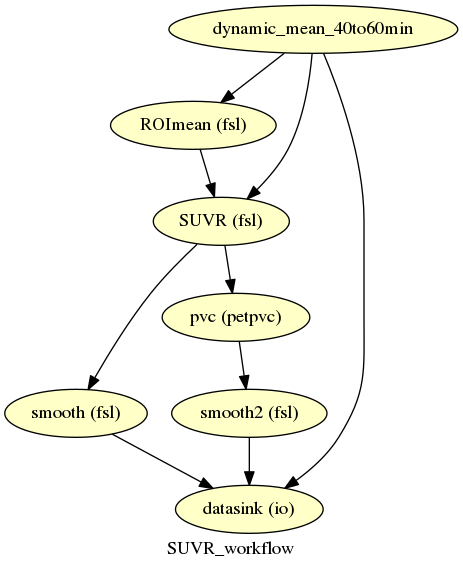

In [413]:
# Compute 40 to 60 min mean image for SUVR computation
dynamic_mean_40to60min = Node(interface=DynamicMean(startTime=startTime_40to60min, endTime=endTime_40to60min),
                              name="dynamic_mean_40to60min")
ROImean = Node(interface=fsl.ImageStats(op_string=' -k %s -m '), name="ROImean") # note that this is not a trimmed mean!
SUVR = Node(interface=fsl.ImageMaths(), name="SUVR")

multiply = Node(interface=fsl.ImageMaths(op_string=' -mul 1', suffix='_mul', output_type='NIFTI_PAIR'),
                name='multiply')

# Gaussian smoothing of SUVR
smooth = Node(interface=fsl.Smooth(fwhm=smooth_fwhm), name="smooth")
smooth2 = Node(interface=fsl.Smooth(fwhm=smooth_fwhm), name="smooth2")

ROImeans = JoinNode(interface=ROI_means_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'SUVR_ROI.xlsx'),
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans")

pvc = Node(interface=petpvc.PETPVC(pvc='RBV', fwhm_x=pvc_fwhm_x, fwhm_y=pvc_fwhm_y, fwhm_z=pvc_fwhm_z), name="pvc")

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','SUVR_wf')
datasink.inputs.substitutions = [('_idvi_',sitePrefix+'_'),
                                 ('_merged',''),
                                 ('_flirt','_coreg'),
                                 ('_mean','_avg40to60min'),
                                 ('_maths','_suvr'),
                                 ('_reoriented','')
                                ]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r'')]

SUVR_workflow = Workflow(name="SUVR_workflow")
SUVR_workflow.base_dir = os.path.join(output_dir,'SUVR_workingdir')
SUVR_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'SUVR_crashdumps')}}
SUVR_workflow.connect([(dynamic_mean_40to60min, ROImean, [('meanImgFile','in_file')]),
                       (dynamic_mean_40to60min, SUVR, [('meanImgFile','in_file')]),
                       (ROImean, SUVR, [(('out_stat',to_div_string),'op_string')]),
                       (SUVR, smooth, [('out_file','in_file')]),

                       #(smooth, ROImeans, [('smoothed_file','imgFileList')]), # this creates issues due to a bug in JoinNode - I think the bug is fixed in the current developer version on nipype

                       (SUVR, pvc, [('out_file','in_file')]),
                       (pvc, smooth2, [('out_file','in_file')]),

                       (dynamic_mean_40to60min, datasink, [('meanImgFile','avg40to60min')]),
                       (smooth, datasink, [('smoothed_file','SUVR')]),
                       (smooth2, datasink, [('smoothed_file','SUVR_pvc')]),
                      ])

SUVR_workflow.write_graph('SUVR.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'SUVR_workingdir','SUVR_workflow','SUVR.dot.png'))

In [414]:
pib_workflow.connect([# SUVR computation
                      (coreg_workflow, SUVR_workflow, [('realignedpib.pib', 'dynamic_mean_40to60min.timeSeriesImgFile')]),
                      (realign_workflow, SUVR_workflow, [('getpibtiming.pibtiming','dynamic_mean_40to60min.frameTimingCsvFile')]),
                      (labels_workflow, SUVR_workflow, [('erode.out_file','ROImean.mask_file'),
                                                        ('pvc_labels.roi4DMaskFile','pvc.mask_file')])
                                                        #('muselabel.muselabel','ROImeans.labelImgFileList')])
                     ])
result = pib_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})

(-0.5, 127.5, 34.5, -0.5)

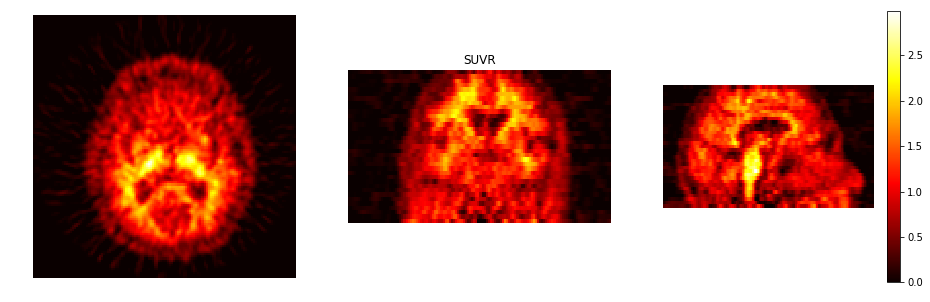

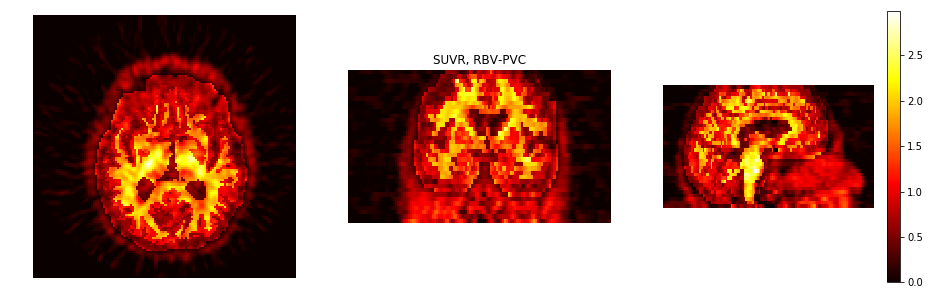

In [398]:
suvrfile = glob(os.path.join(output_dir,'output','SUVR_wf','SUVR',sitePrefix+'_'+idvi_example,
                                     '*.nii*'))[0]
suvrpvcfile = glob(os.path.join(output_dir,'output','SUVR_wf','SUVR_pvc',sitePrefix+'_'+idvi_example,
                                     '*.nii*'))[0]

suvr = nib.load(suvrfile)
I = suvr.get_data()
imdim = I.shape
voxsize = suvr.header.get_zooms()
vmin, vmax = np.percentile(np.abs(I),[5,100])

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('SUVR')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


suvrpvc = nib.load(suvrpvcfile)
I = suvrpvc.get_data()
imdim = I.shape
voxsize = suvrpvc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('SUVR, RBV-PVC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')

## 7. DVR IMAGE

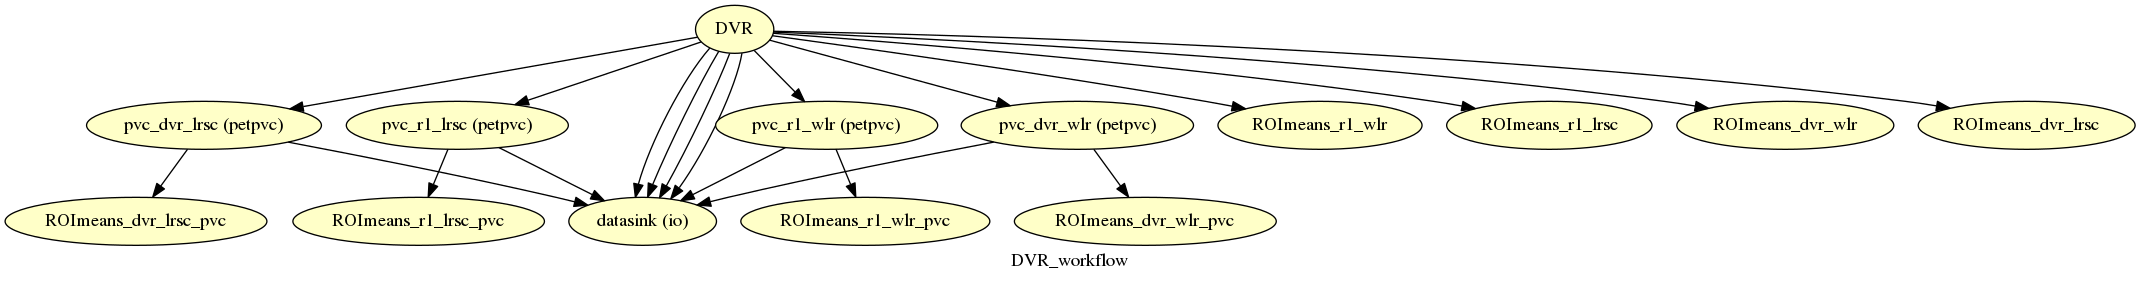

In [415]:
DVR = Node(interface=SRTM(endTime=endTime_DVR, proportiontocut=proportiontocut, fwhm=smooth_fwhm), name="DVR")

ROImeans_dvr_wlr = JoinNode(interface=ROI_means_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'DVR_wlr_ROI.xlsx'),
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_dvr_wlr")

ROImeans_r1_wlr = JoinNode(interface=ROI_means_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'R1_wlr_ROI.xlsx'),
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_r1_wlr")

ROImeans_dvr_lrsc = JoinNode(interface=ROI_means_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'DVR_lrsc_ROI.xlsx'),
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_dvr_lrsc")

ROImeans_r1_lrsc = JoinNode(interface=ROI_means_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'R1_lrsc_ROI.xlsx'),
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_r1_lrsc")


ROImeans_dvr_wlr_pvc = JoinNode(interface=ROI_means_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'DVR_wlr_pvc_ROI.xlsx'),
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_dvr_wlr_pvc")

ROImeans_r1_wlr_pvc = JoinNode(interface=ROI_means_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'R1_wlr_pvc_ROI.xlsx'),
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_r1_wlr_pvc")

ROImeans_dvr_lrsc_pvc = JoinNode(interface=ROI_means_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'DVR_lrsc_pvc_ROI.xlsx'),
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_dvr_lrsc_pvc")

ROImeans_r1_lrsc_pvc = JoinNode(interface=ROI_means_to_spreadsheet(ROI_list=list(ROIs.values()),
                                             ROI_names=list(ROIs.keys()),
                                             additionalROIs=list(compositeROIs.values()),
                                             additionalROI_names=list(compositeROIs.keys()),
                                             xlsxFile=os.path.join(output_dir,'R1_lrsc_pvc_ROI.xlsx'),
                                             proportiontocut=proportiontocut),
                    joinsource="infosource", joinfield=['imgFileList','labelImgFileList'], name="ROImeans_r1_lrsc_pvc")

pvc_dvr_wlr = Node(interface=petpvc.PETPVC(pvc='RBV', fwhm_x=pvc_fwhm_x, fwhm_y=pvc_fwhm_y, fwhm_z=pvc_fwhm_z), name="pvc_dvr_wlr")
pvc_r1_wlr = pvc_dvr_wlr.clone(name='pvc_r1_wlr')
pvc_dvr_lrsc = pvc_dvr_wlr.clone(name='pvc_dvr_lrsc')
pvc_r1_lrsc = pvc_dvr_wlr.clone(name='pvc_r1_lrsc')

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','DVR_wf')
datasink.inputs.substitutions = [('_idvi_',sitePrefix+'_'),
                                 ('_merged',''),
                                 ('_reoriented','')
                                ]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r''),
                                        (r'_\d+\.\d+min',r'')]

DVR_workflow = Workflow(name="DVR_workflow")
DVR_workflow.base_dir = os.path.join(output_dir,'DVR_workingdir')
DVR_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'DVR_crashdumps')}}
DVR_workflow.connect([(DVR, ROImeans_dvr_wlr, [('DVRImgFile_wlr','imgFileList')]),
                      (DVR, ROImeans_r1_wlr, [('R1ImgFile_wlr','imgFileList')]),
                      (DVR, ROImeans_dvr_lrsc, [('DVRImgFile_lrsc','imgFileList')]),
                      (DVR, ROImeans_r1_lrsc, [('DVRImgFile_lrsc','imgFileList')]),

                      (DVR, pvc_dvr_wlr, [('DVRImgFile_wlr','in_file')]),
                      (DVR, pvc_r1_wlr, [('R1ImgFile_wlr','in_file')]),
                      (DVR, pvc_dvr_lrsc, [('DVRImgFile_lrsc','in_file')]),
                      (DVR, pvc_r1_lrsc, [('R1ImgFile_lrsc','in_file')]),

                      (pvc_dvr_wlr, ROImeans_dvr_wlr_pvc, [('out_file','imgFileList')]),
                      (pvc_r1_wlr, ROImeans_r1_wlr_pvc, [('out_file','imgFileList')]),
                      (pvc_dvr_lrsc, ROImeans_dvr_lrsc_pvc, [('out_file','imgFileList')]),
                      (pvc_r1_lrsc, ROImeans_r1_lrsc_pvc, [('out_file','imgFileList')]),

                      (DVR, datasink, [('DVRImgFile_wlr','wlr'),
                                       ('R1ImgFile_wlr','wlr.@R1'),
                                       ('DVRImgFile_lrsc','lrsc'),
                                       ('R1ImgFile_lrsc','lrsc.@R1')]),
                      (pvc_dvr_wlr, datasink, [('out_file','wlr_pvc')]),
                      (pvc_r1_wlr, datasink, [('out_file','wlr_pvc.@R1')]),
                      (pvc_dvr_lrsc, datasink, [('out_file','lrsc_pvc')]),
                      (pvc_r1_lrsc, datasink, [('out_file','lrsc_pvc.@R1')]),
                     ])

DVR_workflow.write_graph('DVR.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'DVR_workingdir','DVR_workflow','DVR.dot.png'))

In [416]:
pib_workflow.connect([# DVR computation
                      (coreg_workflow, DVR_workflow, [('realignedpib.pib', 'DVR.timeSeriesImgFile')]),
                      (realign_workflow, DVR_workflow, [('getpibtiming.pibtiming','DVR.frameTimingCsvFile')]),
                      (labels_workflow, DVR_workflow, [('erode.out_file','DVR.refRegionMaskFile'),
                                                       ('pvc_labels.roi4DMaskFile','pvc_dvr_wlr.mask_file'),
                                                       ('pvc_labels.roi4DMaskFile','pvc_r1_wlr.mask_file'),
                                                       ('pvc_labels.roi4DMaskFile','pvc_dvr_lrsc.mask_file'),
                                                       ('pvc_labels.roi4DMaskFile','pvc_r1_lrsc.mask_file'),
                                                       ('muselabel.muselabel','ROImeans_dvr_wlr.labelImgFileList'),
                                                       ('muselabel.muselabel','ROImeans_r1_wlr.labelImgFileList'),
                                                       ('muselabel.muselabel','ROImeans_dvr_lrsc.labelImgFileList'),
                                                       ('muselabel.muselabel','ROImeans_r1_lrsc.labelImgFileList'),
                                                       ('muselabel.muselabel','ROImeans_dvr_wlr_pvc.labelImgFileList'),
                                                       ('muselabel.muselabel','ROImeans_r1_wlr_pvc.labelImgFileList'),
                                                       ('muselabel.muselabel','ROImeans_dvr_lrsc_pvc.labelImgFileList'),
                                                       ('muselabel.muselabel','ROImeans_r1_lrsc_pvc.labelImgFileList')])
                     ])
result = pib_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})

(-0.5, 127.5, 34.5, -0.5)

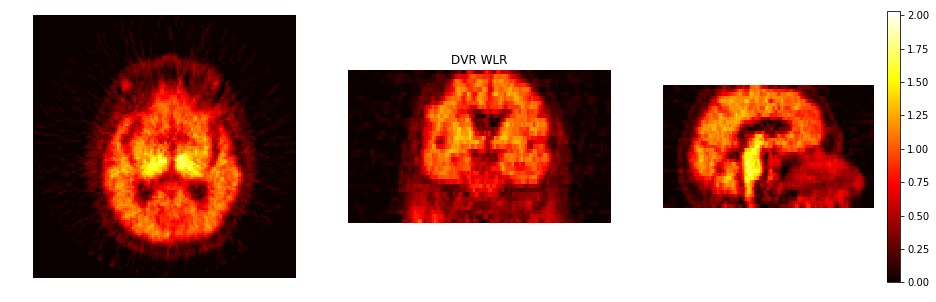

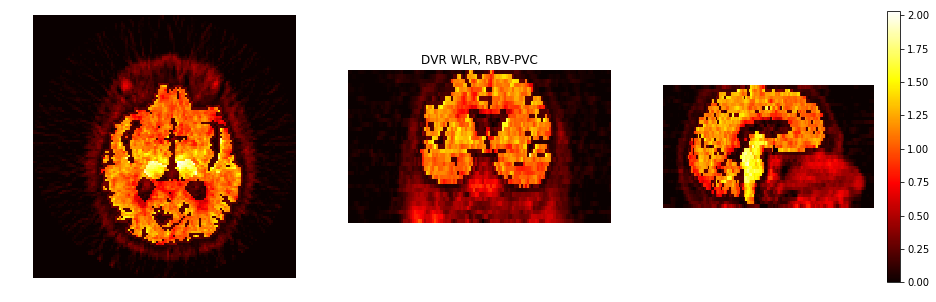

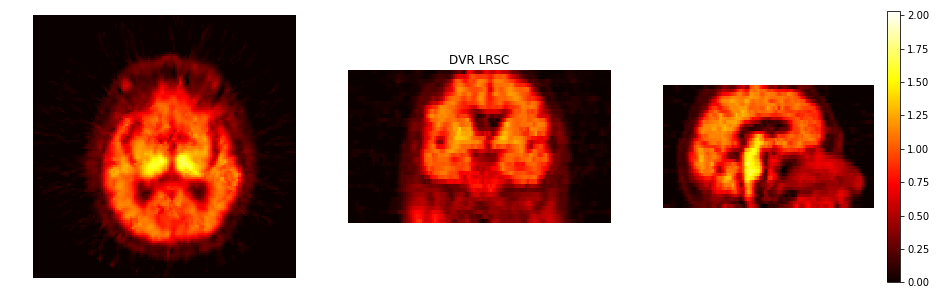

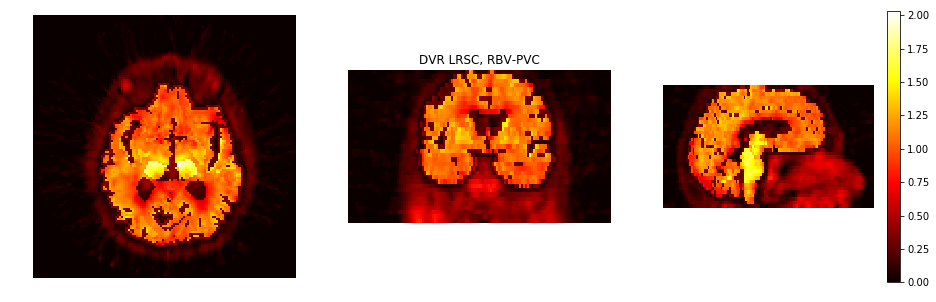

In [420]:
dvrwlrfile = glob(os.path.join(output_dir,'output','DVR_wf','wlr',sitePrefix+'_'+idvi_example,
                                     '*DVR*.nii*'))[0]
dvrwlrpvcfile = glob(os.path.join(output_dir,'output','DVR_wf','wlr_pvc',sitePrefix+'_'+idvi_example,
                                     '*DVR*.nii*'))[0]
dvrlrscfile = glob(os.path.join(output_dir,'output','DVR_wf','lrsc',sitePrefix+'_'+idvi_example,
                                     '*DVR*.nii*'))[0]
dvrlrscpvcfile = glob(os.path.join(output_dir,'output','DVR_wf','lrsc_pvc',sitePrefix+'_'+idvi_example,
                                     '*DVR*.nii*'))[0]

dvrwlr = nib.load(dvrwlrfile)
I = dvrwlr.get_data()
imdim = I.shape
voxsize = dvrwlr.header.get_zooms()
vmin, vmax = np.percentile(np.abs(I),[5,100])

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('DVR WLR')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


dvrwlrpvc = nib.load(dvrwlrpvcfile)
I = dvrwlrpvc.get_data()
imdim = I.shape
voxsize = dvrwlrpvc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('DVR WLR, RBV-PVC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


dvrlrsc = nib.load(dvrlrscfile)
I = dvrlrsc.get_data()
imdim = I.shape
voxsize = dvrlrsc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('DVR LRSC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


dvrlrscpvc = nib.load(dvrlrscpvcfile)
I = dvrlrscpvc.get_data()
imdim = I.shape
voxsize = dvrlrscpvc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('DVR LRSC, RBV-PVC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')

(-0.5, 127.5, 34.5, -0.5)

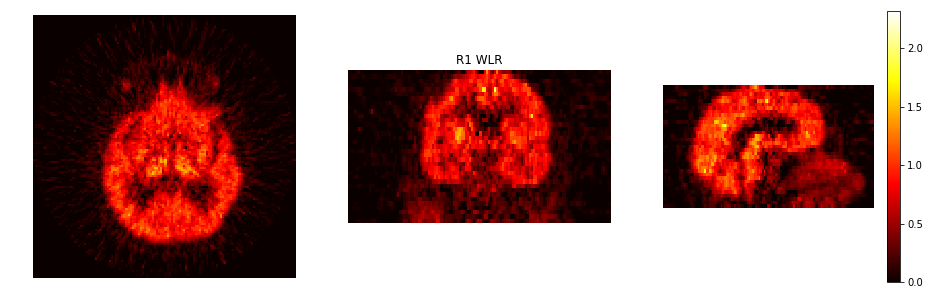

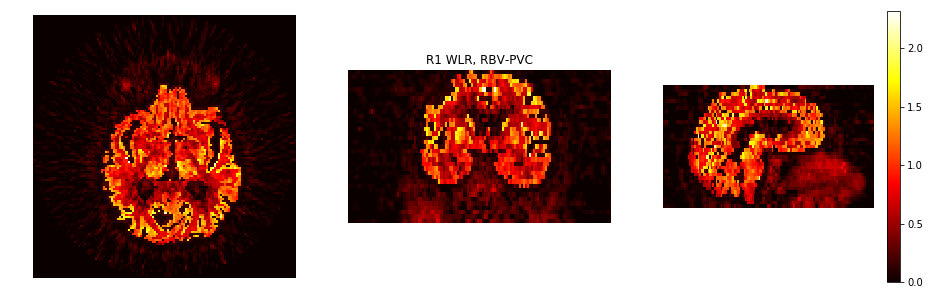

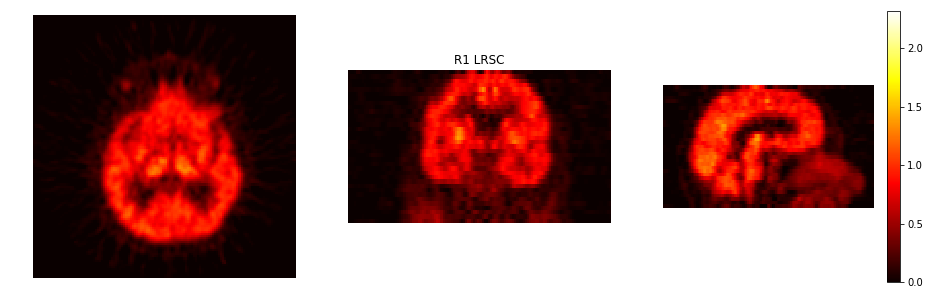

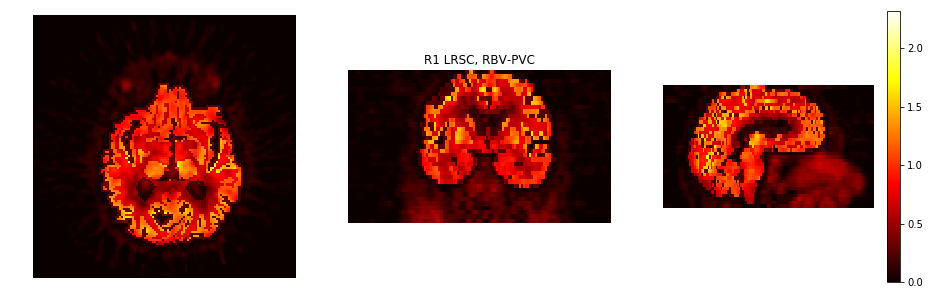

In [422]:
r1wlrfile = glob(os.path.join(output_dir,'output','DVR_wf','wlr',sitePrefix+'_'+idvi_example,
                                     '*R1*.nii*'))[0]
r1wlrpvcfile = glob(os.path.join(output_dir,'output','DVR_wf','wlr_pvc',sitePrefix+'_'+idvi_example,
                                     '*R1*.nii*'))[0]
r1lrscfile = glob(os.path.join(output_dir,'output','DVR_wf','lrsc',sitePrefix+'_'+idvi_example,
                                     '*R1*.nii*'))[0]
r1lrscpvcfile = glob(os.path.join(output_dir,'output','DVR_wf','lrsc_pvc',sitePrefix+'_'+idvi_example,
                                     '*R1*.nii*'))[0]

r1wlr = nib.load(r1wlrfile)
I = r1wlr.get_data()
imdim = I.shape
voxsize = r1wlr.header.get_zooms()
vmin, vmax = np.percentile(np.abs(I),[5,100])

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('R1 WLR')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


r1wlrpvc = nib.load(r1wlrpvcfile)
I = r1wlrpvc.get_data()
imdim = I.shape
voxsize = r1wlrpvc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('R1 WLR, RBV-PVC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


r1lrsc = nib.load(r1lrscfile)
I = r1lrsc.get_data()
imdim = I.shape
voxsize = r1lrsc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('R1 LRSC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')


r1lrscpvc = nib.load(r1lrscpvcfile)
I = r1lrscpvc.get_data()
imdim = I.shape
voxsize = r1lrscpvc.header.get_zooms()

fig = plt.figure(figsize=(16,5))
plt.subplot(131)
plt.imshow(np.fliplr(I[:,:,imdim[2]//2]).T, aspect=voxsize[1]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.subplot(132)
plt.imshow(np.fliplr(I[:,imdim[1]//2,:]).T, aspect=voxsize[2]/voxsize[0], cmap='hot', vmin=vmin, vmax=vmax)
plt.axis('off')
plt.title('R1 LRSC, RBV-PVC')
plt.subplot(133)
im = plt.imshow(np.fliplr(I[imdim[0]//2,:,:]).T, aspect=voxsize[2]/voxsize[1], cmap='hot', vmin=vmin, vmax=vmax)
fig.colorbar(im)
plt.axis('off')

## 8. MNI SPACE

/usr/local/anaconda3/lib/python3.5/site-packages/nipype/interfaces/base.py:431: UserWarning: Input concat_xfm requires inputs: in_file2
  warn(msg)


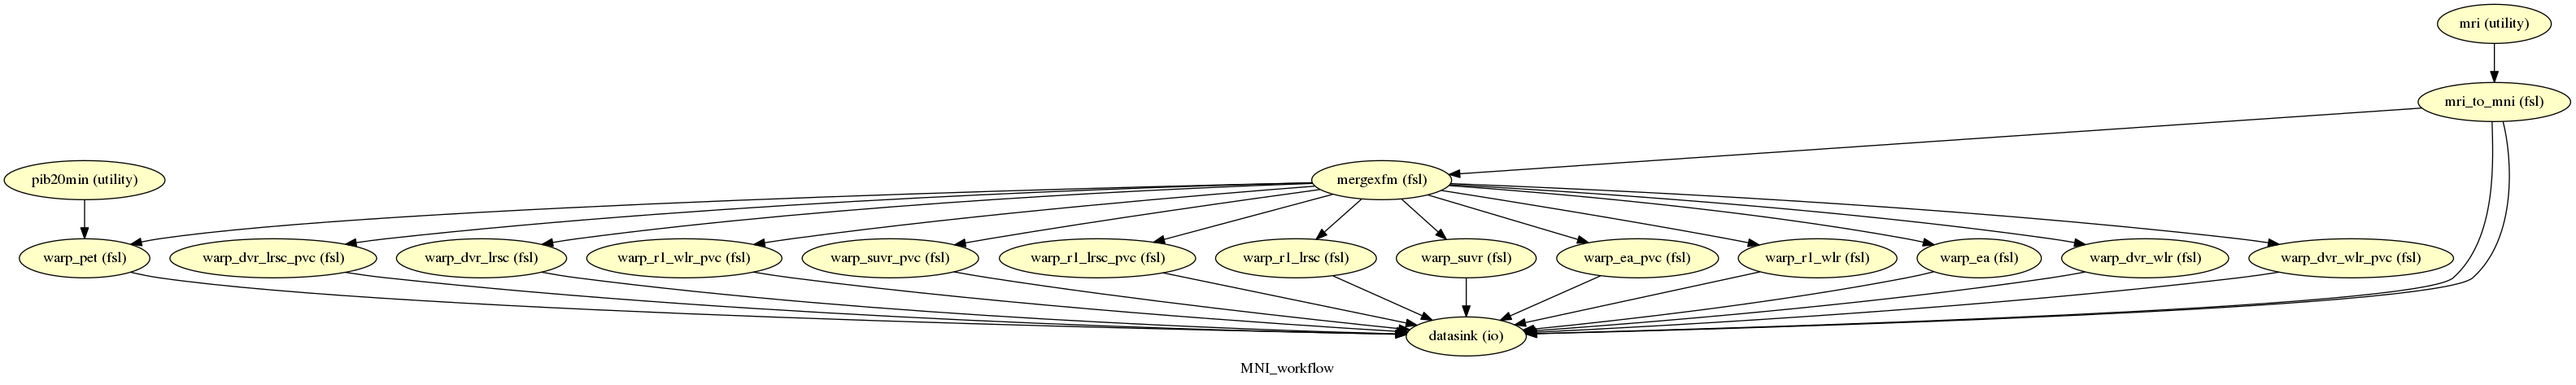

In [424]:
template = fsl.Info.standard_image('MNI152_T1_1mm_brain.nii.gz')

# placeholders
mri = Node(interface=IdentityInterface(fields=['mri']), name="mri")
pib20min = Node(interface=IdentityInterface(fields=['pib20min']), name="pib20min")

# Very quick registration to MNI template
mri_to_mni = Node(interface=fsl.FLIRT(dof=12,reference=template), name="mri_to_mni")

mergexfm = Node(interface=fsl.ConvertXFM(concat_xfm=True), name="mergexfm")

warp_pet = Node(interface=fsl.ApplyXfm(apply_xfm=True, reference=template), name='warp_pet')

warp_dvr_wlr = warp_pet.clone(name='warp_dvr_wlr')
warp_r1_wlr = warp_pet.clone(name='warp_r1_wlr')
warp_dvr_lrsc = warp_pet.clone(name='warp_dvr_lrsc')
warp_r1_lrsc = warp_pet.clone(name='warp_r1_lrsc')
warp_suvr = warp_pet.clone(name='warp_suvr')
warp_ea = warp_pet.clone(name='warp_ea')

warp_dvr_wlr_pvc = warp_pet.clone(name='warp_dvr_wlr_pvc')
warp_r1_wlr_pvc = warp_pet.clone(name='warp_r1_wlr_pvc')
warp_dvr_lrsc_pvc = warp_pet.clone(name='warp_dvr_lrsc_pvc')
warp_r1_lrsc_pvc = warp_pet.clone(name='warp_r1_lrsc_pvc')
warp_suvr_pvc = warp_pet.clone(name='warp_suvr_pvc')
warp_ea_pvc = warp_pet.clone(name='warp_ea_pvc')

datasink = Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = output_dir
datasink.inputs.container = os.path.join('output','MNI_wf')
datasink.inputs.substitutions = [('_idvi_',sitePrefix+'_'),
                                 ('_merged',''),
                                 ('_reoriented',''),
                                 ('_trans','_mni'),
                                 ('flirt','mni'),
                                ]
datasink.inputs.regexp_substitutions = [(r'_\d+\.\d+to\d+\.\d+min',r''),
                                        (r'_\d+\.\d+min',r'')]

MNI_workflow = Workflow(name="MNI_workflow")
MNI_workflow.base_dir = os.path.join(output_dir,'MNI_workingdir')
MNI_workflow.config = {"execution": {"crashdump_dir": os.path.join(output_dir,'MNI_crashdumps')}}
MNI_workflow.connect([(mri, mri_to_mni, [('mri','in_file')]),

                      (mri_to_mni, mergexfm, [('out_matrix_file','in_file2')]),

                      (pib20min, warp_pet, [('pib20min','in_file')]),
                      (mergexfm, warp_pet, [('out_file', 'in_matrix_file')]),

                      (mergexfm, warp_dvr_wlr, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_r1_wlr, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_dvr_lrsc, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_r1_lrsc, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_suvr, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_ea, [('out_file','in_matrix_file')]),

                      (mergexfm, warp_dvr_wlr_pvc, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_r1_wlr_pvc, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_dvr_lrsc_pvc, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_r1_lrsc_pvc, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_suvr_pvc, [('out_file','in_matrix_file')]),
                      (mergexfm, warp_ea_pvc, [('out_file','in_matrix_file')]),

                      (mri_to_mni, datasink, [('out_file','warped_mri'),
                                              ('out_matrix_file','warped_mri.@param')]),
                      (warp_pet, datasink, [('out_file','warped_pet')]),

                      (warp_dvr_wlr, datasink, [('out_file','warped_dvr_wlr')]),
                      (warp_r1_wlr, datasink, [('out_file','warped_r1_wlr')]),
                      (warp_dvr_lrsc, datasink, [('out_file','warped_dvr_lrsc')]),
                      (warp_r1_lrsc, datasink, [('out_file','warped_r1_lrsc')]),
                      (warp_suvr, datasink, [('out_file','warped_suvr')]),
                      (warp_ea, datasink, [('out_file','warped_ea')]),

                      (warp_dvr_wlr_pvc, datasink, [('out_file','warped_dvr_wlr_pvc')]),
                      (warp_r1_wlr_pvc, datasink, [('out_file','warped_r1_wlr_pvc')]),
                      (warp_dvr_lrsc_pvc, datasink, [('out_file','warped_dvr_lrsc_pvc')]),
                      (warp_r1_lrsc_pvc, datasink, [('out_file','warped_r1_lrsc_pvc')]),
                      (warp_suvr_pvc, datasink, [('out_file','warped_suvr_pvc')]),
                      (warp_ea_pvc, datasink, [('out_file','warped_ea_pvc')]),
                     ])

MNI_workflow.write_graph('MNI.dot', graph2use='colored', simple_form=True)
Image(filename=os.path.join(output_dir,'MNI_workingdir','MNI_workflow','MNI.dot.png'))

In [425]:
pib_workflow.connect([# MNI space normalization
                      (coreg_workflow, MNI_workflow, [('reorientmri.out_file','mri.mri'),
                                                      ('dynamic_mean_20min.meanImgFile','pib20min.pib20min'),
                                                      ('pet_to_mri.out_matrix_file','mergexfm.in_file')]),
                      (DVR_workflow, MNI_workflow, [('DVR.DVRImgFile_wlr','warp_dvr_wlr.in_file'),
                                                    ('DVR.R1ImgFile_wlr','warp_r1_wlr.in_file'),
                                                    ('DVR.DVRImgFile_lrsc','warp_dvr_lrsc.in_file'),
                                                    ('DVR.R1ImgFile_lrsc','warp_r1_lrsc.in_file'),
                                                    ('pvc_dvr_wlr.out_file','warp_dvr_wlr_pvc.in_file'),
                                                    ('pvc_r1_wlr.out_file','warp_r1_wlr_pvc.in_file'),
                                                    ('pvc_dvr_lrsc.out_file','warp_dvr_lrsc_pvc.in_file'),
                                                    ('pvc_r1_lrsc.out_file','warp_r1_lrsc_pvc.in_file')]),
                      (SUVR_workflow, MNI_workflow, [('smooth.smoothed_file','warp_suvr.in_file'),
                                                     ('smooth2.smoothed_file','warp_suvr_pvc.in_file')]),
                      (EA_workflow, MNI_workflow, [('dynamic_mean_EA.meanImgFile','warp_ea.in_file'),
                                                   ('pvc.out_file','warp_ea_pvc.in_file')])
                     ])
result = pib_workflow.run('MultiProc', plugin_args={'n_procs': n_procs, 'status_callback': log_nodes_cb})